# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Загрузка данных
labels_df = pd.read_csv('/datasets/faces/labels.csv')

labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [2]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В целом, хотя 7591 фотографий - неплохое количество данных, их достаточности для обучения модели регрессии нельзя утверждать однозначно. Важно провести анализ данных и эксперименты, чтобы оценить качество модели и ее способность обобщать на новые данные.

In [3]:
# Извлечение данных из папки с изображениями
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory="/datasets/faces/final_files/",
    x_col='file_name',
    y_col='real_age',
    batch_size=16,
    class_mode='raw',
    target_size=(224, 224)# или другой размер, подходящий для вашей модели
)

Found 7591 validated image filenames.


In [4]:
# Размер выборки
num_samples = len(labels_df)
print("Размер выборки:", num_samples)

Размер выборки: 7591


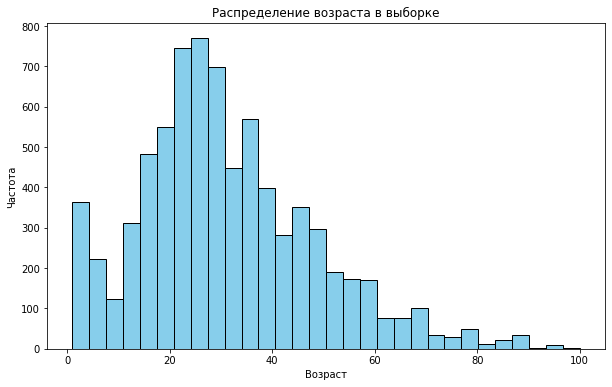

In [5]:
# График распределения возраста
plt.figure(figsize=(10, 6))
plt.hist(labels_df['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

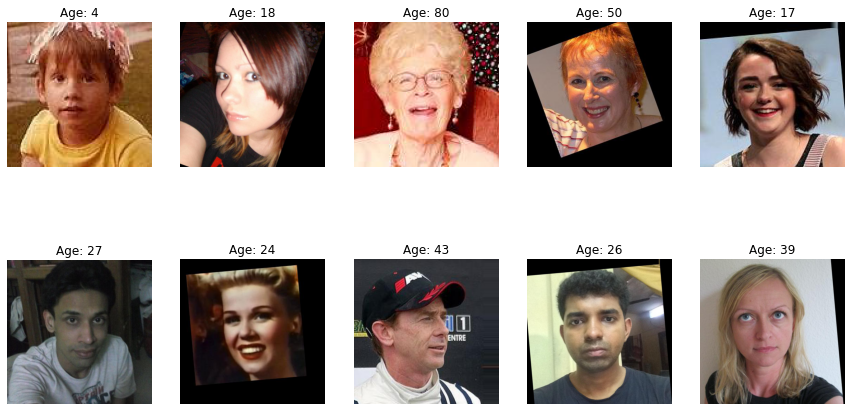

In [6]:
# Отображение изображений
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = plt.imread('/datasets/faces/final_files/' + labels_df['file_name'][i])
    plt.imshow(img)
    plt.title('Age: ' + str(labels_df['real_age'][i]))
    plt.axis('off')
plt.show()

Вывод:
1. Размер выборки достаточно большой, 7591 фотография, что явно сделает время обучения моделей не быстрым
2. График распределения возраста нормальный, имеется преобладание молодого возраста (от 20 до 30 лет), правда есть так же большое количество фотографий людей детского возраста(от 0 до 10 лет)
3. Датасет предоставляет нам фотографии рандомных людей, не сортируемых ни по каким признакам. Некоторые фотографии в датасате имеют искаженный вид(Повернуты или отдалены от рамки).

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121

# Функция загрузки данных для обучения
def load_train(path):
    # Чтение меток из CSV файла
    train_df = pd.read_csv(path + 'labels.csv')

    # Создание генератора изображений для обучения с аугментацией и нормализацией данных
    datagen = ImageDataGenerator(
        rescale=1/255.,
        horizontal_flip=True,
        validation_split=0.25)  

    # Создание потока данных для обучения
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=path + 'final_files/',
        x_col='file_name',  
        y_col='real_age',    
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',  
        subset='training',
        seed=12345)

    return train_datagen_flow

# Функция загрузки данных для тестирования
def load_test(path):
    # Чтение меток из CSV файла
    test_df = pd.read_csv(path + 'labels.csv')
    
    # Создание генератора изображений для тестирования с нормализацией данных
    datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.25)
 
    # Создание потока данных для тестирования
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=path + 'final_files/',
        x_col='file_name',  
        y_col='real_age',    
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',  
        subset='validation',
        seed=12345)
 
    return test_datagen_flow

# Функция создания модели
def create_model(input_shape):
    # Загрузка предварительно обученной модели DenseNet121 с весами ImageNet
    backbone = DenseNet121(input_shape=input_shape,
                           weights='imagenet', 
                           include_top=False)
    
    # Создание последовательной модели
    model = Sequential()
    # Добавление предварительно обученной модели в качестве основы
    model.add(backbone)
    # Добавление слоя глобального среднего пулинга
    model.add(GlobalAveragePooling2D())
    # Добавление полносвязного слоя с одним выходом и линейной активацией
    model.add(Dense(1, activation='linear')) 
    
    # Компиляция модели с оптимизатором Adam и метрикой MeanAbsoluteError
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_absolute_error', metrics=[MeanAbsoluteError()])
 
    return model

# Функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    # Обучение модели с использованием переданных данных
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2024-02-26 12:04:09.109876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-26 12:04:09.413196: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 59s - loss: 20.3103 - mean_absolute_error: 20.3114 - val_loss: 17.9989 - val_mean_absolute_error: 17.9917
Epoch 2/10
356/356 - 41s - loss: 10.2749 - mean_absolute_error: 10.2744 - val_loss: 8.2143 - val_mean_absolute_error: 8.2174
Epoch 3/10
356/356 - 41s - loss: 8.4095 - mean_absolute_error: 8.4092 - val_loss: 8.1769 - val_mean_absolute_error: 8.1746
Epoch 4/10
356/356 - 41s - loss: 7.6500 - mean_absolute_error: 7.6505 - val_loss: 7.1401 - val_mean_absolute_error: 7.1394
Epoch 5/10
356/356 - 41s - loss: 7.1213 - mean_absolute_error: 7.1221 - val_loss: 6.9592 - val_mean_absolute_error: 6.9687
Epoch 6/10
356/356 - 41s - loss: 6.7198 - mean_absolute_error: 6.7198 - val_loss: 7.4006 - val_mean_absolute_error: 7.4110
Epoch 7/10
356/356 - 41s - loss: 6.4176 - mean_absolute_error: 6.4180 - val_loss: 7.0167 - val_mean_absolute_error: 7.0287
Epoch 8/10
356/356 - 41s - loss: 6.1521 - mean_absolute_error: 6.1516 - val_loss: 7.1690 - val_mean_absolute_error: 7.1787
Epoch 9/10
356/356 - 41s - loss: 5.9053 - mean_absolute_error: 5.9051 - val_loss: 6.4715 - val_mean_absolute_error: 6.4858
Epoch 10/10
356/356 - 41s - loss: 5.7347 - mean_absolute_error: 5.7344 - val_loss: 6.4675 - val_mean_absolute_error: 6.4813
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 6.2788 - mean_absolute_error: 6.2930
Test MAE: 6.2930

```

## Анализ обученной модели

**Вывод:** Во время работы над проектом была выполнена загрузка данных и их извлечение. Далее было проанализировано распределение возрастов в данных и выгружены несколько фотографий. Далее была обучена и протестирована модель, которая выдала результат MAE: 6.2930, что подходит нам, ведь цель была меньше 8.

Анализ самой модели:

1. **Использованная архитектура:** В коде используется архитектура нейронной сети, основанная на предварительно обученной модели DenseNet121. Предварительно обученные веса загружаются из ImageNet.


2. **Параметры обучения:**
   - **Размер батча:** Размер батча установлен в 16 для как обучающего, так и тестового набора данных.
   - **Оптимизатор:** Для компиляции модели используется оптимизатор Adam с коэффициентом скорости обучения (learning rate) 0.0001.
   - **Заморозка весов бэкбона:** Веса бэкбона (DenseNet121) не заморожены, поскольку они загружаются из предварительно обученной модели.
   - **Количество эпох:** Установлено количество эпох равное 10.


3. **Достигнутые метрики и переобучение:**
   - Для оценки качества модели используется метрика Mean Absolute Error (средняя абсолютная ошибка).
   - Переобучение не наблюдается.